##  Baseline 2 Model: ResNet-50 + CRNN + BiLSTM + CTC

### Model Defination

In [38]:
!pip install jiwer

In [39]:
# === Section 1: Imports, Model, Initialization ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns

# === Tracking variables for ResNet-50 CRNN ===
train_losses_resnet50 = []
val_losses_resnet50 = []
cer_list_resnet50 = []
wer_list_resnet50 = []
sentence_lengths_resnet50 = []
cer_by_length_resnet50 = []

class CRNN_OCR_ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.cnn = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(input_size=1024, hidden_size=256, num_layers=2,
                           bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        features = self.cnn(x)
        features = self.adaptive_pool(features).squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)
        return output

vocab_size = len(tokenizer)
model_crnn_resnet50 = CRNN_OCR_ResNet50(num_classes=vocab_size).to(device)
ctc_loss_fn_resnet50 = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_resnet50 = torch.optim.AdamW(model_crnn_resnet50.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


### Training Loop

In [40]:
from tqdm import tqdm
import torch.nn.functional as F
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt

num_epochs = 20
best_model_path = "best_model_resnet50.pth"

for epoch in range(num_epochs):
    model_crnn_resnet50.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # === Train Loop with Progress Bar ===
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")
    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet50(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss_fn_resnet50(log_probs, targets, input_lengths, label_lengths)

        optimizer_resnet50.zero_grad()
        loss.backward()
        optimizer_resnet50.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet50.append(avg_train_loss)

    # === Evaluation (PER EPOCH) ===
    model_crnn_resnet50.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet50(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = F.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn_resnet50(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())

                cer_val = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_val = wer(true_text, pred_text)

                total_cer += cer_val
                total_wer += wer_val
                sentence_lengths_resnet50.append(len(true_text))
                cer_by_length_resnet50.append(cer_val)
                sample_count += 1

    avg_val_loss_resnet50 = total_val_loss / len(test_loader)
    avg_cer_resnet50 = total_cer / sample_count
    avg_wer_resnet50 = total_wer / sample_count

    val_losses_resnet50.append(avg_val_loss_resnet50)
    cer_list_resnet50.append(avg_cer_resnet50)
    wer_list_resnet50.append(avg_wer_resnet50)

    # === Save best ResNet50 model based on CER ===
    if len(cer_list_resnet50) == 1 or avg_cer_resnet50 < min(cer_list_resnet50[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet50.state_dict(),
            'optimizer_state_dict': optimizer_resnet50.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path)
        print(f"\n Saved best ResNet50 model (epoch {epoch + 1}) with CER: {avg_cer_resnet50:.4f}")

    print(f"\nResNet50 CRNN | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss_resnet50:.4f} | CER: {avg_cer_resnet50:.4f} | WER: {avg_wer_resnet50:.4f}")
    print(f"Final Scores for Epoch (ResNet50 CRNN):")
    print(f"Avg Train Loss: {train_losses_resnet50[-1]:.4f}")
    print(f"Avg Val Loss:   {val_losses_resnet50[-1]:.4f}")
    print(f"Final CER:      {cer_list_resnet50[-1]:.4f}")
    print(f"Final WER:      {wer_list_resnet50[-1]:.4f}")


Epoch 1/20


Training: 100%|██████████| 5007/5007 [06:37<00:00, 12.60batch/s, loss=0.453]



 Saved best ResNet50 model (epoch 1) with CER: 0.3678

ResNet50 CRNN | Train Loss: 1.7153 | Val Loss: 0.4509 | CER: 0.3678 | WER: 0.6736
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 1.7153
Avg Val Loss:   0.4509
Final CER:      0.3678
Final WER:      0.6736

Epoch 2/20


Training: 100%|██████████| 5007/5007 [06:33<00:00, 12.72batch/s, loss=0.0616]



 Saved best ResNet50 model (epoch 2) with CER: 0.3173

ResNet50 CRNN | Train Loss: 0.3360 | Val Loss: 0.2636 | CER: 0.3173 | WER: 0.6134
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.3360
Avg Val Loss:   0.2636
Final CER:      0.3173
Final WER:      0.6134

Epoch 3/20


Training: 100%|██████████| 5007/5007 [06:35<00:00, 12.66batch/s, loss=0.396]



ResNet50 CRNN | Train Loss: 0.2255 | Val Loss: 0.2104 | CER: 0.3373 | WER: 0.5705
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.2255
Avg Val Loss:   0.2104
Final CER:      0.3373
Final WER:      0.5705

Epoch 4/20


Training: 100%|██████████| 5007/5007 [06:35<00:00, 12.66batch/s, loss=0.0475]



ResNet50 CRNN | Train Loss: 0.1746 | Val Loss: 0.1971 | CER: 0.3539 | WER: 0.6460
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1746
Avg Val Loss:   0.1971
Final CER:      0.3539
Final WER:      0.6460

Epoch 5/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.18]



 Saved best ResNet50 model (epoch 5) with CER: 0.3136

ResNet50 CRNN | Train Loss: 0.1414 | Val Loss: 0.1680 | CER: 0.3136 | WER: 0.5559
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1414
Avg Val Loss:   0.1680
Final CER:      0.3136
Final WER:      0.5559

Epoch 6/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.129]



 Saved best ResNet50 model (epoch 6) with CER: 0.3063

ResNet50 CRNN | Train Loss: 0.1173 | Val Loss: 0.1296 | CER: 0.3063 | WER: 0.5251
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.1173
Avg Val Loss:   0.1296
Final CER:      0.3063
Final WER:      0.5251

Epoch 7/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0542]



ResNet50 CRNN | Train Loss: 0.0970 | Val Loss: 0.1195 | CER: 0.3491 | WER: 0.6093
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0970
Avg Val Loss:   0.1195
Final CER:      0.3491
Final WER:      0.6093

Epoch 8/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0126]



ResNet50 CRNN | Train Loss: 0.0829 | Val Loss: 0.1044 | CER: 0.3683 | WER: 0.6350
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0829
Avg Val Loss:   0.1044
Final CER:      0.3683
Final WER:      0.6350

Epoch 9/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0209]



ResNet50 CRNN | Train Loss: 0.0711 | Val Loss: 0.1023 | CER: 0.3141 | WER: 0.5137
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0711
Avg Val Loss:   0.1023
Final CER:      0.3141
Final WER:      0.5137

Epoch 10/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.069]



ResNet50 CRNN | Train Loss: 0.0614 | Val Loss: 0.0796 | CER: 0.3477 | WER: 0.5697
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0614
Avg Val Loss:   0.0796
Final CER:      0.3477
Final WER:      0.5697

Epoch 11/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.121]



ResNet50 CRNN | Train Loss: 0.0541 | Val Loss: 0.0803 | CER: 0.3501 | WER: 0.5905
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0541
Avg Val Loss:   0.0803
Final CER:      0.3501
Final WER:      0.5905

Epoch 12/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0225]



ResNet50 CRNN | Train Loss: 0.0474 | Val Loss: 0.0709 | CER: 0.3248 | WER: 0.5482
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0474
Avg Val Loss:   0.0709
Final CER:      0.3248
Final WER:      0.5482

Epoch 13/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0395]



ResNet50 CRNN | Train Loss: 0.0420 | Val Loss: 0.0628 | CER: 0.3601 | WER: 0.6178
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0420
Avg Val Loss:   0.0628
Final CER:      0.3601
Final WER:      0.6178

Epoch 14/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.77batch/s, loss=0.0254]



ResNet50 CRNN | Train Loss: 0.0375 | Val Loss: 0.0802 | CER: 0.3284 | WER: 0.5558
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0375
Avg Val Loss:   0.0802
Final CER:      0.3284
Final WER:      0.5558

Epoch 15/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.029]



ResNet50 CRNN | Train Loss: 0.0333 | Val Loss: 0.0709 | CER: 0.3774 | WER: 0.6363
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0333
Avg Val Loss:   0.0709
Final CER:      0.3774
Final WER:      0.6363

Epoch 16/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.00384]



ResNet50 CRNN | Train Loss: 0.0326 | Val Loss: 0.0556 | CER: 0.3563 | WER: 0.5960
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0326
Avg Val Loss:   0.0556
Final CER:      0.3563
Final WER:      0.5960

Epoch 17/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0774]



ResNet50 CRNN | Train Loss: 0.0285 | Val Loss: 0.0657 | CER: 0.3384 | WER: 0.6000
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0285
Avg Val Loss:   0.0657
Final CER:      0.3384
Final WER:      0.6000

Epoch 18/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.76batch/s, loss=0.0153]



ResNet50 CRNN | Train Loss: 0.0266 | Val Loss: 0.0626 | CER: 0.3583 | WER: 0.6062
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0266
Avg Val Loss:   0.0626
Final CER:      0.3583
Final WER:      0.6062

Epoch 19/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.0302]



ResNet50 CRNN | Train Loss: 0.0243 | Val Loss: 0.0505 | CER: 0.3702 | WER: 0.6340
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0243
Avg Val Loss:   0.0505
Final CER:      0.3702
Final WER:      0.6340

Epoch 20/20


Training: 100%|██████████| 5007/5007 [06:32<00:00, 12.75batch/s, loss=0.00475]



ResNet50 CRNN | Train Loss: 0.0220 | Val Loss: 0.0583 | CER: 0.3883 | WER: 0.6203
Final Scores for Epoch (ResNet50 CRNN):
Avg Train Loss: 0.0220
Avg Val Loss:   0.0583
Final CER:      0.3883
Final WER:      0.6203


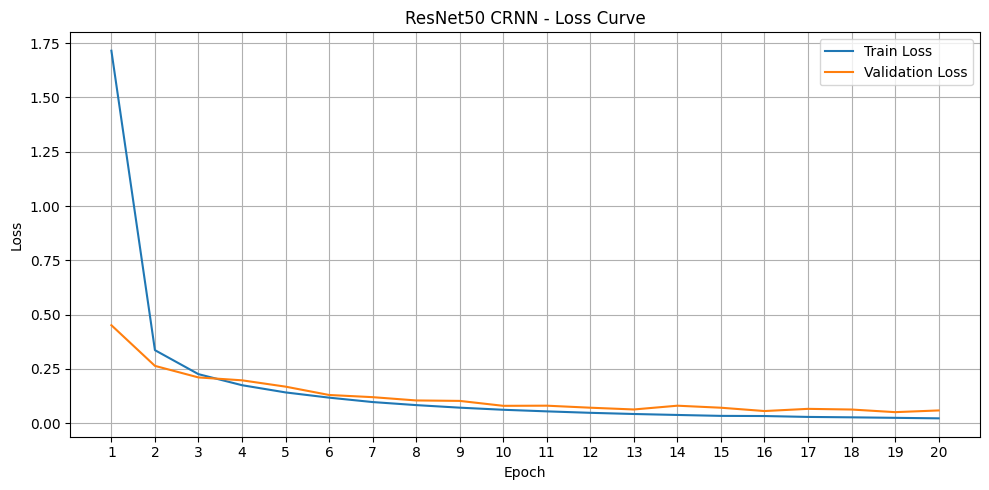

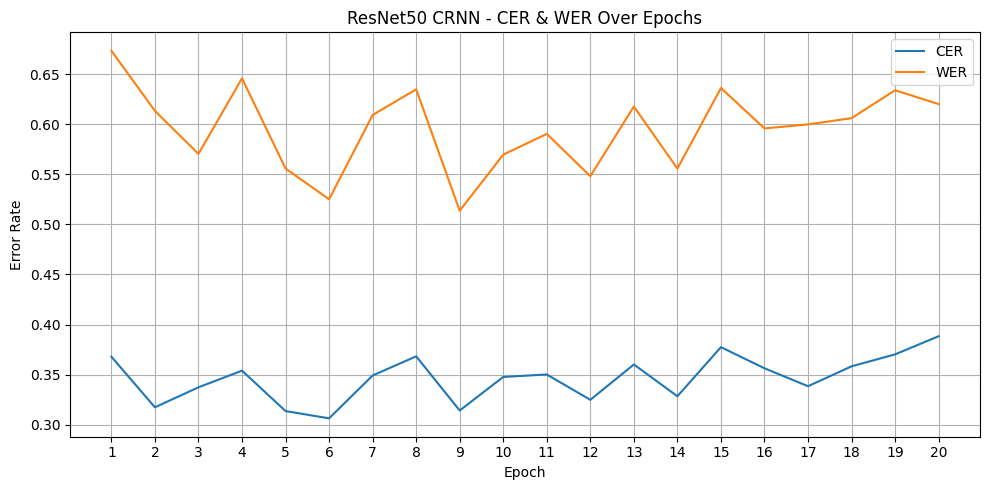

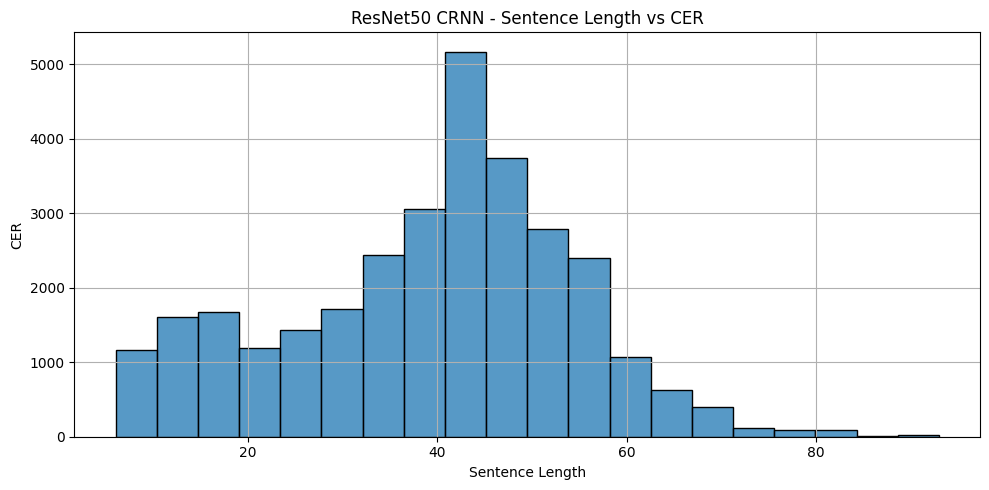

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure epoch indexing starts from 1
epochs = list(range(1, len(train_losses_resnet50) + 1))

# === Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet50, label='Train Loss')
plt.plot(epochs, val_losses_resnet50, label='Validation Loss')
plt.title('ResNet50 CRNN - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === CER & WER over Epochs ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet50, label='CER')
plt.plot(epochs, wer_list_resnet50, label='WER')
plt.title('ResNet50 CRNN - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sentence Length vs CER ===
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet50, weights=cer_by_length_resnet50, bins=20, kde=False)
plt.title('ResNet50 CRNN - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from jiwer import cer

total_cer_resnet50 = 0
sample_count_resnet50 = 0

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet50(images)  # [W, B, C]
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet50 >= 10:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, decoded)
            total_cer_resnet50 += cer_score

            print(f"Predicted: {decoded}")
            print(f"Actual   : {target_text}")
            print(f"CER      : {cer_score:.3f}")
            print("----")

            sample_count_resnet50 += 1

        if sample_count_resnet50 >= 10:
            break

avg_cer_resnet50 = total_cer_resnet50 / sample_count_resnet50
print(f"\nAverage CER (ResNet50) over {sample_count_resnet50} samples: {avg_cer_resnet50:.3f}")

Predicted: <hi>  कााल  ममें  अररब  के  अमीरर  ममुल्क़़  भी  करर्ज़़  लेने  पर  हुुए
Actual   : <hi> काल में अरब के अमीर मुल्क़ भी कर्ज़ लेने पर हुए
CER      : 0.385
----
Predicted: <hi>  ट््ररंप:  ललगतताा है किि  अदााललतेंं भी  सििियााससीी  हो गगई
Actual   : <hi> ट्रंप: लगता है कि अदालतें भी सियासी हो गई
CER      : 0.435
----
Predicted: <hi>  वर्ल्ड  कप   20019:  ऑसस्ट्रेलिियाा  ने  वेस्टइंंडीज़़  कोो ररनोंं सेे
Actual   : <hi> वर्ल्ड कप 2019: ऑस्ट्रेलिया ने वेस्टइंडीज़ को रनों से
CER      : 0.310
----
Predicted: <en> thee  year  thee  ministeer  wroote  ppersonallly to  some  two
Actual   : <en> the year the minister wrote personally to some two
CER      : 0.236
----
Predicted: <hi>  रूूस  ककी  योजननााा   पर   पी--5  देेशोंं  ककी
Actual   : <hi> रूस की योजना पर पी-5 देशों की
CER      : 0.529
----
Predicted: <en>  rreecoord     anyway
Actual   : <en> record  anyway
CER      : 0.368
----
Predicted: <en> a lot   of  iit  iis   mmeviitaabble  sso  tthat   iinndustrry   annd
Actual   : <en

# ResNet 101



In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.5 MB/s eta 0:00:00


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
import seaborn as sns

# === Tracking variables for ResNet-101 CRNN ===
train_losses_resnet101 = []
val_losses_resnet101 = []
cer_list_resnet101 = []
wer_list_resnet101 = []
sentence_lengths_resnet101 = []
cer_by_length_resnet101 = []


class CRNN_OCR_ResNet101(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet101, self).__init__()

        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-3]  # Keep up to conv4_x
        self.cnn = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

        self.rnn = nn.LSTM(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # Grayscale to RGB
        features = self.cnn(x)
        features = self.adaptive_pool(features)
        features = features.squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)  # [W, B, num_classes]
        return output


In [44]:
vocab_size = len(tokenizer)
model_crnn_resnet101 = CRNN_OCR_ResNet101(num_classes=vocab_size).to(device)

ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_crnn_resnet101 = torch.optim.AdamW(model_crnn_resnet101.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_crnn_resnet101, mode='min', factor=0.5, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 228MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.war

In [45]:
from tqdm import tqdm
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt

num_epochs = 20
best_model_path = "best_model_resnet101.pth"

for epoch in range(num_epochs):
    model_crnn_resnet101.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")

    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet101(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)

        optimizer_crnn_resnet101.zero_grad()
        loss.backward()
        optimizer_crnn_resnet101.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet101.append(avg_train_loss)

    model_crnn_resnet101.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet101(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())
                cer_score = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_score = wer(true_text, pred_text)

                total_cer += cer_score
                total_wer += wer_score
                sentence_lengths_resnet101.append(len(true_text))
                cer_by_length_resnet101.append(cer_score)
                sample_count += 1

    avg_val_loss = total_val_loss / len(test_loader)
    avg_cer = total_cer / sample_count
    avg_wer = total_wer / sample_count

    val_losses_resnet101.append(avg_val_loss)
    cer_list_resnet101.append(avg_cer)
    wer_list_resnet101.append(avg_wer)

    scheduler.step(avg_val_loss)

    # Save best model based on CER
    if len(cer_list_resnet101) == 1 or avg_cer < min(cer_list_resnet101[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet101.state_dict(),
            'optimizer_state_dict': optimizer_crnn_resnet101.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path)
        print(f"\n Saved best model (epoch {epoch + 1}) with CER: {avg_cer:.4f}")

    print(f"ResNet101 CRNN | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")
    print(f"\nFinal Scores (ResNet101 CRNN):")
    print(f"Avg Train Loss: {train_losses_resnet101[-1]:.4f}")
    print(f"Avg Val Loss:   {val_losses_resnet101[-1]:.4f}")
    print(f"Final CER:      {cer_list_resnet101[-1]:.4f}")
    print(f"Final WER:      {wer_list_resnet101[-1]:.4f}")


Epoch 1/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.173]



 Saved best model (epoch 1) with CER: 0.3402
ResNet101 CRNN | Train Loss: 1.4164 | Val Loss: 0.3703 | CER: 0.3402 | WER: 0.5907

Final Scores (ResNet101 CRNN):
Avg Train Loss: 1.4164
Avg Val Loss:   0.3703
Final CER:      0.3402
Final WER:      0.5907

Epoch 2/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.444]



 Saved best model (epoch 2) with CER: 0.3259
ResNet101 CRNN | Train Loss: 0.3064 | Val Loss: 0.2571 | CER: 0.3259 | WER: 0.5583

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.3064
Avg Val Loss:   0.2571
Final CER:      0.3259
Final WER:      0.5583

Epoch 3/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.253]


ResNet101 CRNN | Train Loss: 0.2311 | Val Loss: 0.2161 | CER: 0.3265 | WER: 0.5441

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.2311
Avg Val Loss:   0.2161
Final CER:      0.3265
Final WER:      0.5441

Epoch 4/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.224]



 Saved best model (epoch 4) with CER: 0.2850
ResNet101 CRNN | Train Loss: 0.1886 | Val Loss: 0.1983 | CER: 0.2850 | WER: 0.4777

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1886
Avg Val Loss:   0.1983
Final CER:      0.2850
Final WER:      0.4777

Epoch 5/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.57batch/s, loss=0.114]



 Saved best model (epoch 5) with CER: 0.2612
ResNet101 CRNN | Train Loss: 0.1621 | Val Loss: 0.1740 | CER: 0.2612 | WER: 0.5182

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1621
Avg Val Loss:   0.1740
Final CER:      0.2612
Final WER:      0.5182

Epoch 6/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.277]


ResNet101 CRNN | Train Loss: 0.1387 | Val Loss: 0.1530 | CER: 0.2868 | WER: 0.4850

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1387
Avg Val Loss:   0.1530
Final CER:      0.2868
Final WER:      0.4850

Epoch 7/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.107]


ResNet101 CRNN | Train Loss: 0.1190 | Val Loss: 0.1380 | CER: 0.2939 | WER: 0.5315

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1190
Avg Val Loss:   0.1380
Final CER:      0.2939
Final WER:      0.5315

Epoch 8/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0688]


ResNet101 CRNN | Train Loss: 0.1015 | Val Loss: 0.1157 | CER: 0.2780 | WER: 0.4029

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.1015
Avg Val Loss:   0.1157
Final CER:      0.2780
Final WER:      0.4029

Epoch 9/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0559]


ResNet101 CRNN | Train Loss: 0.0849 | Val Loss: 0.1043 | CER: 0.3434 | WER: 0.4998

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0849
Avg Val Loss:   0.1043
Final CER:      0.3434
Final WER:      0.4998

Epoch 10/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.54batch/s, loss=0.0611]


ResNet101 CRNN | Train Loss: 0.0752 | Val Loss: 0.1065 | CER: 0.3214 | WER: 0.5297

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0752
Avg Val Loss:   0.1065
Final CER:      0.3214
Final WER:      0.5297

Epoch 11/20


Training: 100%|██████████| 5007/5007 [08:45<00:00,  9.53batch/s, loss=0.12]


ResNet101 CRNN | Train Loss: 0.0651 | Val Loss: 0.0957 | CER: 0.3427 | WER: 0.5309

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0651
Avg Val Loss:   0.0957
Final CER:      0.3427
Final WER:      0.5309

Epoch 12/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.0219]


ResNet101 CRNN | Train Loss: 0.0571 | Val Loss: 0.0849 | CER: 0.3291 | WER: 0.5211

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0571
Avg Val Loss:   0.0849
Final CER:      0.3291
Final WER:      0.5211

Epoch 13/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0863]


ResNet101 CRNN | Train Loss: 0.0482 | Val Loss: 0.0748 | CER: 0.2873 | WER: 0.4448

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0482
Avg Val Loss:   0.0748
Final CER:      0.2873
Final WER:      0.4448

Epoch 14/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0261]


ResNet101 CRNN | Train Loss: 0.0448 | Val Loss: 0.0843 | CER: 0.2985 | WER: 0.4454

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0448
Avg Val Loss:   0.0843
Final CER:      0.2985
Final WER:      0.4454

Epoch 15/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.145]


ResNet101 CRNN | Train Loss: 0.0414 | Val Loss: 0.0674 | CER: 0.3457 | WER: 0.5118

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0414
Avg Val Loss:   0.0674
Final CER:      0.3457
Final WER:      0.5118

Epoch 16/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.0228]


ResNet101 CRNN | Train Loss: 0.0360 | Val Loss: 0.0548 | CER: 0.3160 | WER: 0.5038

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0360
Avg Val Loss:   0.0548
Final CER:      0.3160
Final WER:      0.5038

Epoch 17/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.271]


ResNet101 CRNN | Train Loss: 0.0304 | Val Loss: 0.0573 | CER: 0.3245 | WER: 0.4734

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0304
Avg Val Loss:   0.0573
Final CER:      0.3245
Final WER:      0.4734

Epoch 18/20


Training: 100%|██████████| 5007/5007 [08:43<00:00,  9.56batch/s, loss=0.00112]


ResNet101 CRNN | Train Loss: 0.0286 | Val Loss: 0.0493 | CER: 0.3335 | WER: 0.4678

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0286
Avg Val Loss:   0.0493
Final CER:      0.3335
Final WER:      0.4678

Epoch 19/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.55batch/s, loss=0.183]


ResNet101 CRNN | Train Loss: 0.0279 | Val Loss: 0.0462 | CER: 0.3371 | WER: 0.4990

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0279
Avg Val Loss:   0.0462
Final CER:      0.3371
Final WER:      0.4990

Epoch 20/20


Training: 100%|██████████| 5007/5007 [08:44<00:00,  9.56batch/s, loss=0.105]


ResNet101 CRNN | Train Loss: 0.0241 | Val Loss: 0.0503 | CER: 0.3855 | WER: 0.5842

Final Scores (ResNet101 CRNN):
Avg Train Loss: 0.0241
Avg Val Loss:   0.0503
Final CER:      0.3855
Final WER:      0.5842


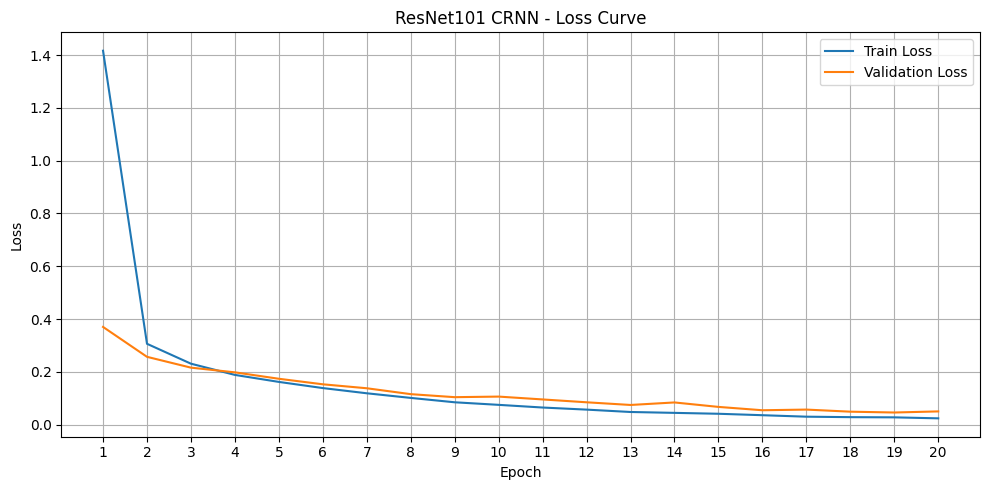

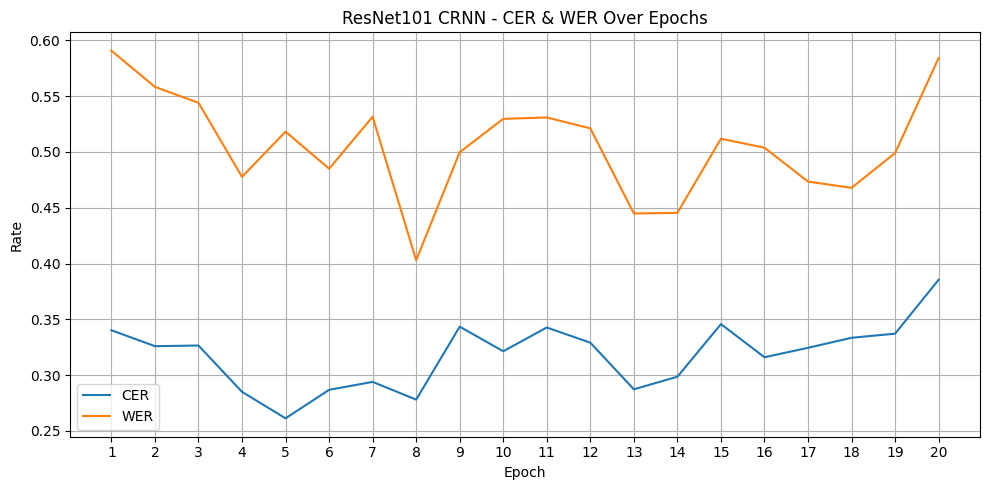

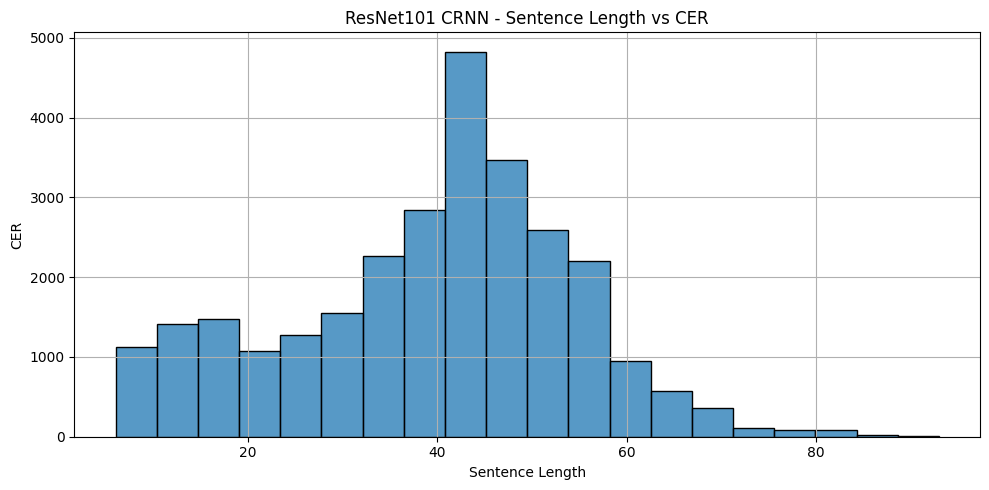

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = list(range(1, len(train_losses_resnet101) + 1))

# === Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet101, label='Train Loss')
plt.plot(epochs, val_losses_resnet101, label='Validation Loss')
plt.title('ResNet101 CRNN - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === CER & WER over Epochs ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet101, label='CER')
plt.plot(epochs, wer_list_resnet101, label='WER')
plt.title('ResNet101 CRNN - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sentence Length vs CER ===
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet101, weights=cer_by_length_resnet101, bins=20, kde=False)
plt.title('ResNet101 CRNN - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import cer

total_cer_resnet101 = 0
sample_count_resnet101 = 0

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet101(images)  # [W, B, C]
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet101 >= 10:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, decoded)
            total_cer_resnet101 += cer_score

            print(f"Predicted: {decoded}")
            print(f"Actual   : {target_text}")
            print(f"CER      : {cer_score:.3f}")
            print("----")

            sample_count_resnet101 += 1

        if sample_count_resnet101 >= 10:
            break

avg_cer_resnet101 = total_cer_resnet101 / sample_count_resnet101
print(f"\nAverage CER (ResNet101) over {sample_count_resnet101} samples: {avg_cer_resnet101:.3f}")

Predicted: <en> enggland  annnd   has  made   it   liive
Actual   : <en> england and has made it live
CER      : 0.364
----
Predicted: <en> ennd    the  manufacture   and  use   oof
Actual   : <en> end the manufacture and use of
CER      : 0.314
----
Predicted: <en> iiincrreased  majorriitiiiers
Actual   : <en> increased majorities
CER      : 0.360
----
Predicted: <en>>  tthee
Actual   : <en> the
CER      : 0.500
----
Predicted: <en> wwhiich   lleeft   iits  ceentrraal  ccharracter   and   tthe
Actual   : <en> which left its central character and the
CER      : 0.467
----
Predicted: <en> hiis  face   was  fiiixeed
Actual   : <en> his face was fixed
CER      : 0.348
----
Predicted: <en> mrr  bryan   stonehousses   prooductiion   is   quieently
Actual   : <en> mr bryan stonehouses production is quietly
CER      : 0.319
----
Predicted: <en> thaar  a   human   beeingg    had  an  increasing  numbeer  oof  dissciplees  amonngg
Actual   : <en> than a human being   had an increasing number of

### ResNet101 + symspellpy

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.3 MB/s eta 0:00:00


In [ ]:
# 1. Install and download dictionary
!pip install symspellpy
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt

# 2. Import and initialize
from symspellpy import SymSpell, Verbosity

# 3. Initialize SymSpell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# 4. Load the dictionary
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 15.7 MB/s eta 0:00:00
--2025-05-03 16:56:54--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.06s   

2025-05-03 16:56:54 (22.0 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332881/1332881]



True

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
import editdistance
from jiwer import wer
import matplotlib.pyplot as plt
from tqdm import tqdm
from symspellpy import SymSpell, Verbosity
import re

# === Tracking variables for CRNN ResNet101 v2 ===
train_losses_resnet101_v2 = []
val_losses_resnet101_v2 = []
cer_list_resnet101_v2 = []
wer_list_resnet101_v2 = []
sentence_lengths_resnet101_v2 = []
cer_by_length_resnet101_v2 = []

# === SymSpell Setup ===
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


# Pattern to match tag-like fragments (e.g., <hi>, <<hi>>, hi>, <en>, etc.)
TAG_PATTERN = re.compile(r'^<*<?\s*(hi|hii|en)\s*>*>>*$', re.IGNORECASE)

def symspell_correct(text):
    tokens = text.strip().split()

    if not tokens:
        return text

    first_token = tokens[0].lower()

    # If Hindi tag detected (hi or hii), skip correction entirely
    if "hi" in first_token:  # covers hi, hii, <hi>, <<hii>>, etc.
        return text

    corrected = []
    for i, word in enumerate(tokens):
        # Preserve tag-like tokens (e.g., <en>, <<en>>, en>, etc.)
        if TAG_PATTERN.match(word.lower()):
            corrected.append(word)
            continue

        # Apply SymSpell correction
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected.append(suggestions[0].term if suggestions else word)

    return ' '.join(corrected)


class CRNN_OCR_ResNet101_v2(nn.Module):
    def __init__(self, num_classes):
        super(CRNN_OCR_ResNet101_v2, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-3]  # Keep up to conv4_x
        self.cnn = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.rnn = nn.LSTM(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # Grayscale to RGB
        features = self.cnn(x)
        features = self.adaptive_pool(features)
        features = features.squeeze(2).permute(0, 2, 1)
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out).permute(1, 0, 2)  # [W, B, num_classes]
        return output


vocab_size = len(tokenizer)
model_crnn_resnet101_v2 = CRNN_OCR_ResNet101_v2(num_classes=vocab_size).to(device)

ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer_crnn_resnet101_v2 = torch.optim.AdamW(model_crnn_resnet101_v2.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_crnn_resnet101_v2, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 20
best_model_path_v2 = "best_model_resnet101_v2.pth"

for epoch in range(num_epochs):
    model_crnn_resnet101_v2.train()
    total_train_loss = 0
    total_batches = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loader_progress = tqdm(train_loader, desc="Training", unit="batch")

    for batch in train_loader_progress:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        logits = model_crnn_resnet101_v2(images)
        input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
        targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)

        optimizer_crnn_resnet101_v2.zero_grad()
        loss.backward()
        optimizer_crnn_resnet101_v2.step()

        total_train_loss += loss.item()
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / total_batches
    train_losses_resnet101_v2.append(avg_train_loss)

    model_crnn_resnet101_v2.eval()
    total_val_loss = 0
    total_cer = 0
    total_wer = 0
    sample_count = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)

            logits = model_crnn_resnet101_v2(images)
            input_lengths = torch.full((logits.size(1),), logits.size(0), dtype=torch.long).to(device)
            targets = torch.cat([labels[i][:label_lengths[i]] for i in range(len(labels))]).to(device)

            log_probs = F.log_softmax(logits, dim=2)
            val_loss = ctc_loss_fn(log_probs, targets, input_lengths, label_lengths)
            total_val_loss += val_loss.item()

            preds = logits.softmax(2).argmax(2).permute(1, 0).cpu().numpy()
            for i, pred in enumerate(preds):
                pred_text = tokenizer.decode(pred)
                pred_text = symspell_correct(pred_text)  # <- Post-correction
                true_text = tokenizer.decode(labels[i][:label_lengths[i]].cpu().numpy())

                cer_score = editdistance.eval(pred_text, true_text) / max(1, len(true_text))
                wer_score = wer(true_text, pred_text)

                total_cer += cer_score
                total_wer += wer_score
                sentence_lengths_resnet101_v2.append(len(true_text))
                cer_by_length_resnet101_v2.append(cer_score)
                sample_count += 1

    avg_val_loss = total_val_loss / len(test_loader)
    avg_cer = total_cer / sample_count
    avg_wer = total_wer / sample_count

    val_losses_resnet101_v2.append(avg_val_loss)
    cer_list_resnet101_v2.append(avg_cer)
    wer_list_resnet101_v2.append(avg_wer)

    scheduler.step(avg_val_loss)

    if len(cer_list_resnet101_v2) == 1 or avg_cer < min(cer_list_resnet101_v2[:-1]):
        torch.save({
            'model_state_dict': model_crnn_resnet101_v2.state_dict(),
            'optimizer_state_dict': optimizer_crnn_resnet101_v2.state_dict(),
            'vocab_size': vocab_size,
            'tokenizer_config': tokenizer.char2idx
        }, best_model_path_v2)
        print(f"\n  Saved best model (epoch {epoch + 1}) with CER: {avg_cer:.4f}")

    print(f"ResNet101 CRNN v2 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")
    print(f"\nFinal Scores (ResNet101 CRNN v2):")
    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Avg Val Loss:   {avg_val_loss:.4f}")
    print(f"Final CER:      {avg_cer:.4f}")
    print(f"Final WER:      {avg_wer:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/20


Training: 100%|██████████| 5007/5007 [08:50<00:00,  9.44batch/s, loss=0.517]



  Saved best model (epoch 1) with CER: 0.2268
ResNet101 CRNN v2 | Train Loss: 1.4752 | Val Loss: 0.3861 | CER: 0.2268 | WER: 0.4559

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 1.4752
Avg Val Loss:   0.3861
Final CER:      0.2268
Final WER:      0.4559

Epoch 2/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.325]



  Saved best model (epoch 2) with CER: 0.1778
ResNet101 CRNN v2 | Train Loss: 0.3095 | Val Loss: 0.2577 | CER: 0.1778 | WER: 0.4132

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.3095
Avg Val Loss:   0.2577
Final CER:      0.1778
Final WER:      0.4132

Epoch 3/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.50batch/s, loss=0.168]


ResNet101 CRNN v2 | Train Loss: 0.2270 | Val Loss: 0.2213 | CER: 0.2142 | WER: 0.4459

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.2270
Avg Val Loss:   0.2213
Final CER:      0.2142
Final WER:      0.4459

Epoch 4/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.0927]


ResNet101 CRNN v2 | Train Loss: 0.1886 | Val Loss: 0.2149 | CER: 0.1866 | WER: 0.4206

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1886
Avg Val Loss:   0.2149
Final CER:      0.1866
Final WER:      0.4206

Epoch 5/20


Training: 100%|██████████| 5007/5007 [08:49<00:00,  9.45batch/s, loss=0.302]



  Saved best model (epoch 5) with CER: 0.1576
ResNet101 CRNN v2 | Train Loss: 0.1564 | Val Loss: 0.2087 | CER: 0.1576 | WER: 0.3832

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1564
Avg Val Loss:   0.2087
Final CER:      0.1576
Final WER:      0.3832

Epoch 6/20


Training: 100%|██████████| 5007/5007 [08:51<00:00,  9.43batch/s, loss=0.0361]



  Saved best model (epoch 6) with CER: 0.1387
ResNet101 CRNN v2 | Train Loss: 0.1335 | Val Loss: 0.1427 | CER: 0.1387 | WER: 0.3160

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1335
Avg Val Loss:   0.1427
Final CER:      0.1387
Final WER:      0.3160

Epoch 7/20


Training: 100%|██████████| 5007/5007 [08:46<00:00,  9.52batch/s, loss=0.398]


ResNet101 CRNN v2 | Train Loss: 0.1127 | Val Loss: 0.1245 | CER: 0.1503 | WER: 0.3656

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1127
Avg Val Loss:   0.1245
Final CER:      0.1503
Final WER:      0.3656

Epoch 8/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0304]


ResNet101 CRNN v2 | Train Loss: 0.1002 | Val Loss: 0.1153 | CER: 0.1453 | WER: 0.3461

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.1002
Avg Val Loss:   0.1153
Final CER:      0.1453
Final WER:      0.3461

Epoch 9/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.48batch/s, loss=0.206]


ResNet101 CRNN v2 | Train Loss: 0.0867 | Val Loss: 0.1088 | CER: 0.1624 | WER: 0.3854

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0867
Avg Val Loss:   0.1088
Final CER:      0.1624
Final WER:      0.3854

Epoch 10/20


Training: 100%|██████████| 5007/5007 [08:48<00:00,  9.47batch/s, loss=0.115]


ResNet101 CRNN v2 | Train Loss: 0.0757 | Val Loss: 0.0880 | CER: 0.1440 | WER: 0.3220

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0757
Avg Val Loss:   0.0880
Final CER:      0.1440
Final WER:      0.3220

Epoch 11/20


Training: 100%|██████████| 5007/5007 [08:52<00:00,  9.40batch/s, loss=0.0459]



  Saved best model (epoch 11) with CER: 0.1252
ResNet101 CRNN v2 | Train Loss: 0.0659 | Val Loss: 0.0854 | CER: 0.1252 | WER: 0.2836

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0659
Avg Val Loss:   0.0854
Final CER:      0.1252
Final WER:      0.2836

Epoch 12/20


Training: 100%|██████████| 5007/5007 [08:49<00:00,  9.46batch/s, loss=0.055]


ResNet101 CRNN v2 | Train Loss: 0.0572 | Val Loss: 0.0699 | CER: 0.1259 | WER: 0.3086

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0572
Avg Val Loss:   0.0699
Final CER:      0.1259
Final WER:      0.3086

Epoch 13/20


Training: 100%|██████████| 5007/5007 [08:46<00:00,  9.50batch/s, loss=0.0441]


ResNet101 CRNN v2 | Train Loss: 0.0527 | Val Loss: 0.0734 | CER: 0.1422 | WER: 0.3373

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0527
Avg Val Loss:   0.0734
Final CER:      0.1422
Final WER:      0.3373

Epoch 14/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.50batch/s, loss=0.148]


ResNet101 CRNN v2 | Train Loss: 0.0475 | Val Loss: 0.0670 | CER: 0.1475 | WER: 0.3157

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0475
Avg Val Loss:   0.0670
Final CER:      0.1475
Final WER:      0.3157

Epoch 15/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0298]


ResNet101 CRNN v2 | Train Loss: 0.0411 | Val Loss: 0.0738 | CER: 0.1368 | WER: 0.3110

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0411
Avg Val Loss:   0.0738
Final CER:      0.1368
Final WER:      0.3110

Epoch 16/20


Training: 100%|██████████| 5007/5007 [08:47<00:00,  9.49batch/s, loss=0.0156]


ResNet101 CRNN v2 | Train Loss: 0.0386 | Val Loss: 0.0568 | CER: 0.1388 | WER: 0.3130

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0386
Avg Val Loss:   0.0568
Final CER:      0.1388
Final WER:      0.3130

Epoch 17/20


Training: 100%|██████████| 5007/5007 [08:53<00:00,  9.39batch/s, loss=0.136]


ResNet101 CRNN v2 | Train Loss: 0.0363 | Val Loss: 0.0813 | CER: 0.1426 | WER: 0.3141

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0363
Avg Val Loss:   0.0813
Final CER:      0.1426
Final WER:      0.3141

Epoch 18/20


Training: 100%|██████████| 5007/5007 [08:50<00:00,  9.43batch/s, loss=0.359]


ResNet101 CRNN v2 | Train Loss: 0.0289 | Val Loss: 0.0738 | CER: 0.1314 | WER: 0.2916

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0289
Avg Val Loss:   0.0738
Final CER:      0.1314
Final WER:      0.2916

Epoch 19/20


Training: 100%|██████████| 5007/5007 [08:52<00:00,  9.40batch/s, loss=0.0208]


ResNet101 CRNN v2 | Train Loss: 0.0289 | Val Loss: 0.0545 | CER: 0.1370 | WER: 0.3104

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0289
Avg Val Loss:   0.0545
Final CER:      0.1370
Final WER:      0.3104

Epoch 20/20


Training: 100%|██████████| 5007/5007 [08:51<00:00,  9.41batch/s, loss=0.0213]


ResNet101 CRNN v2 | Train Loss: 0.0272 | Val Loss: 0.0439 | CER: 0.1333 | WER: 0.2900

Final Scores (ResNet101 CRNN v2):
Avg Train Loss: 0.0272
Avg Val Loss:   0.0439
Final CER:      0.1333
Final WER:      0.2900


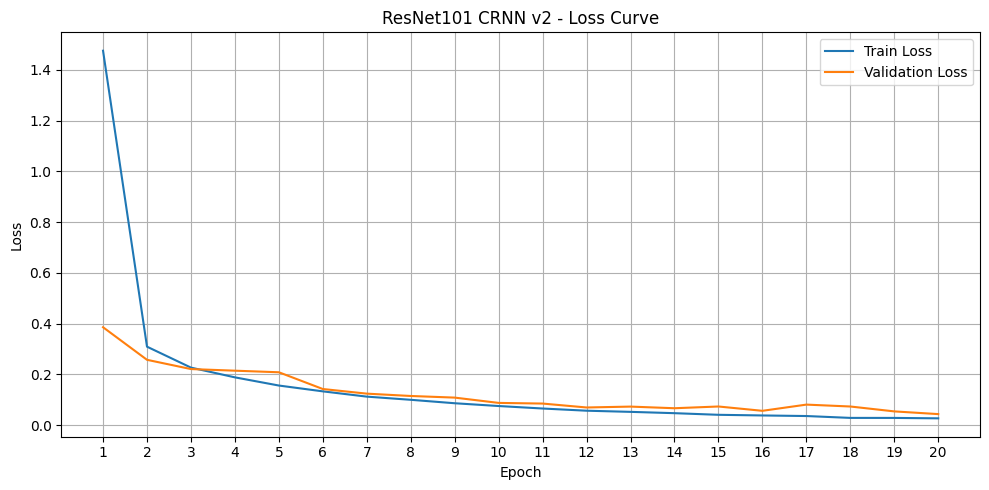

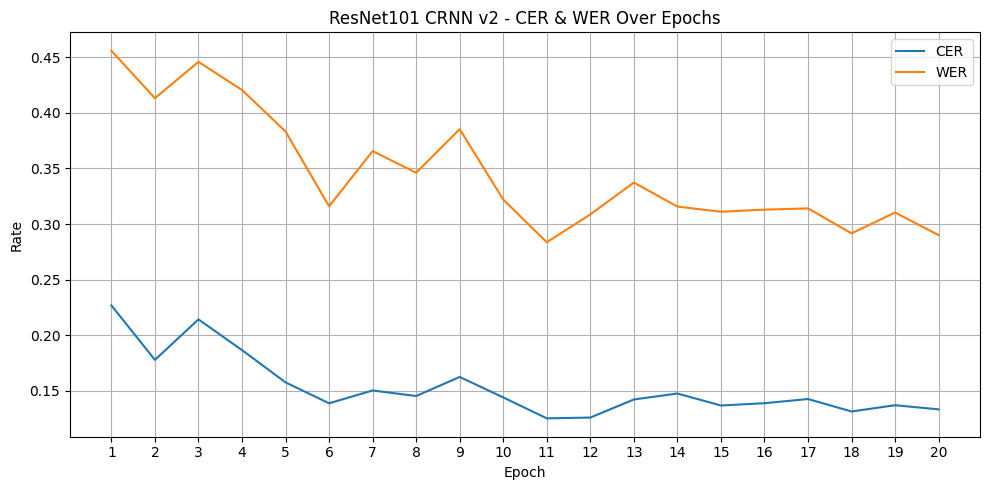

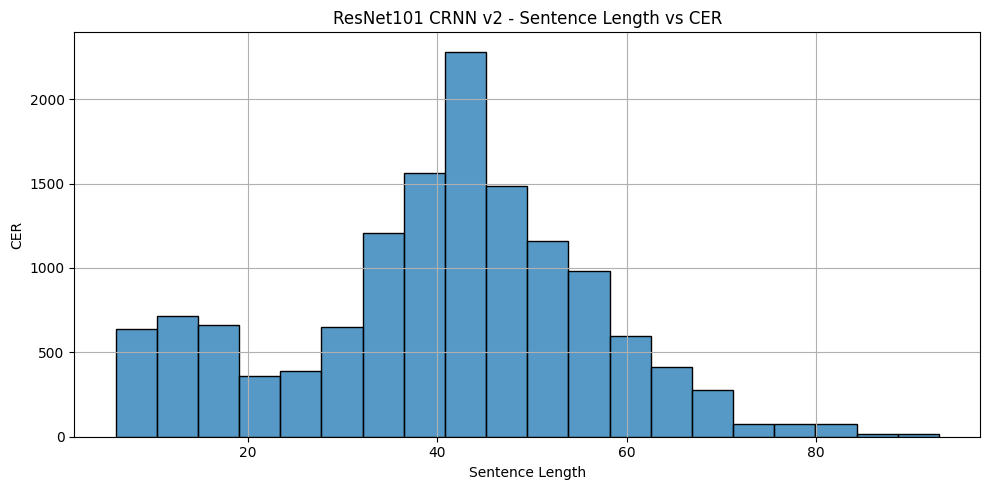

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = list(range(1, len(train_losses_resnet101_v2) + 1))

# === Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_resnet101_v2, label='Train Loss')
plt.plot(epochs, val_losses_resnet101_v2, label='Validation Loss')
plt.title('ResNet101 CRNN v2 - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === CER & WER over Epochs ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, cer_list_resnet101_v2, label='CER')
plt.plot(epochs, wer_list_resnet101_v2, label='WER')
plt.title('ResNet101 CRNN v2 - CER & WER Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sentence Length vs CER ===
plt.figure(figsize=(10, 5))
sns.histplot(x=sentence_lengths_resnet101_v2, weights=cer_by_length_resnet101_v2, bins=20, kde=False)
plt.title('ResNet101 CRNN v2 - Sentence Length vs CER')
plt.xlabel('Sentence Length')
plt.ylabel('CER')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from jiwer import cer

total_cer_resnet101_v2 = 0
sample_count_resnet101_v2 = 0
sample_limit = 10

print("\n Sample Predictions (CRNN ResNet101 v2):\n")

model_crnn_resnet101_v2.eval()

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device)
        labels = batch["labels"]

        logits = model_crnn_resnet101_v2(images)
        preds = logits.softmax(2).argmax(2).permute(1, 0)  # [B, W]

        for i, pred in enumerate(preds):
            if sample_count_resnet101_v2 >= sample_limit:
                break

            decoded = tokenizer.decode(pred.cpu().numpy())
            corrected = symspell_correct(decoded)
            target_text = tokenizer.decode(labels[i].cpu().numpy())

            cer_score = cer(target_text, corrected)
            total_cer_resnet101_v2 += cer_score

            print(f"Predicted : {corrected}")
            print(f"Actual    : {target_text}")
            print(f"CER       : {cer_score:.3f}")
            print("-" * 40)

            sample_count_resnet101_v2 += 1

        if sample_count_resnet101_v2 >= sample_limit:
            break

avg_cer_resnet101_v2 = total_cer_resnet101_v2 / sample_count_resnet101_v2
print(f"\n Average CER (ResNet101 v2) over {sample_count_resnet101_v2} samples: {avg_cer_resnet101_v2:.3f}")


 Sample Predictions (CRNN ResNet101 v2):

Predicted : <hi>  ककााल  मेंं अरब  कके  अमीरर  मुुल्फ़़ भीी  ककर््ज़  लेनेे  पर हुुए
Actual    : <hi> काल में अरब के अमीर मुल्क़ भी कर्ज़ लेने पर हुए
CER       : 0.404
----------------------------------------
Predicted : <hi>  ट््ररंप::  ललगततताा  हैै  ककिि  अदाालतें  भीी  सिियाासी  हो  गईई
Actual    : <hi> ट्रंप: लगता है कि अदालतें भी सियासी हो गई
CER       : 0.522
----------------------------------------
Predicted : <hi>  वर्ल्ड ककप  2019: ऑस्ट्रेलियाा  ने  वेसस्टइंडीीज़़  को  रनों  से
Actual    : <hi> वर्ल्ड कप 2019: ऑस्ट्रेलिया ने वेस्टइंडीज़ को रनों से
CER       : 0.207
----------------------------------------
Predicted : <en> thee year ﻿the minister wrote personally to some two
Actual    : <en> the year the minister wrote personally to some two
CER       : 0.036
----------------------------------------
Predicted : <hi>  रूूस  कीी  योजनाा   पर  पीी--5 देेशोों कीी
Actual    : <hi> रूस की योजना पर पी-5 देशों की
CER       : 0.412
-----------

In [ ]:
def segment_lines_and_show_resnet101(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    hist = np.sum(binary, axis=1)
    h, w = binary.shape
    in_line = False
    top = 0
    boxes = []

    for i in range(h):
        if hist[i] > 0 and not in_line:
            in_line = True
            top = i
        elif hist[i] == 0 and in_line:
            in_line = False
            bottom = i
            if bottom - top > 5:
                boxes.append((top, bottom))
                cv2.rectangle(color_img, (0, top), (w - 1, bottom), (0, 255, 0), 2)

    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Text Lines (ResNet101)")
    plt.axis("off")
    plt.show()

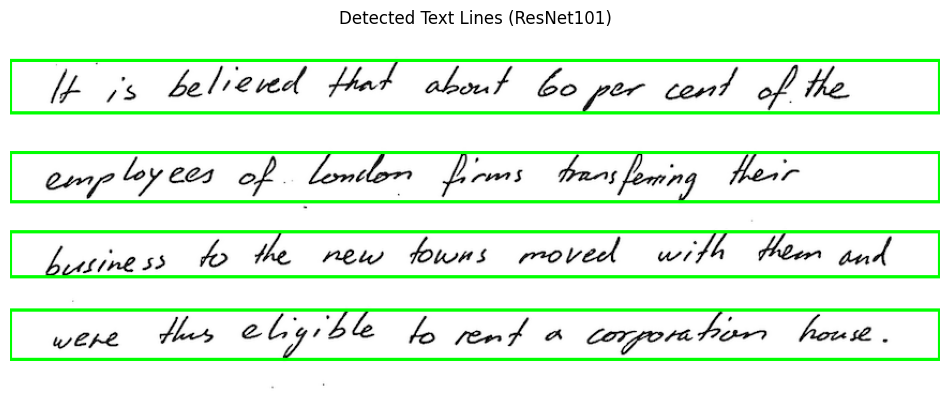

FileNotFoundError: [Errno 2] No such file or directory: 'resnet100_CRNN.pth'

In [ ]:
segment_lines_and_show_resnet101("/content/testIMG.png")
text = extract_text_resnet101("/content/testIMG.png")
print("Predicted Text:\n", text)

## Language Detection

In [ ]:
import fasttext
import torch

# Detect the best available device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure correct path to model file
model_path = "/Users/krishnanand/Documents/Git/Dependencies/lid.176.bin"  # Update this path if necessary
model = fasttext.load_model(model_path)

def detect_language(text):
    """Detect language of given text using FastText."""
    predictions = model.predict(text)
    lang_code = predictions[0][0].replace('__label__', '')
    return lang_code

text = "Bonjour, comment allez-vous?"
detected_lang = detect_language(text)
print(f"Detected Language: {detected_lang}")

## Summarization  

In [ ]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else (0 if torch.backends.mps.is_available() else -1)

# Load summarization pipeline (T5-Base)
summarizer = pipeline("summarization", model="t5-base", device=device)

# Example input text
text = """
Artificial intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems.
These processes include learning, reasoning, and self-correction. AI is one of the most exciting and disruptive technologies
of our time, influencing everything from healthcare to transportation.
"""

# Generate summary
summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
summary_text = summary[0]['summary_text']
print("Summary in English:", summary_text)

# Load translation pipeline with a better model
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es", device=device)

# Translate the summary
translated_summary = translator(summary_text)
print("Translated Summary in Spanish:", translated_summary[0]['translation_text'])

## Translator

In [ ]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else (0 if torch.backends.mps.is_available() else -1)

# Load the NLLB model for French to Hindi translation
translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", device=device)

# Example French text
text = "Bonjour, comment allez-vous aujourd'hui?"

# Translate the text from French to English
translated_text = translator(text, src_lang="fra_Latn", tgt_lang="eng_Latn")
english_translation = translated_text[0]['translation_text']
print("Translated to English:", english_translation)

# Now, translate from English to Hindi
translated_to_hindi = translator(english_translation, src_lang="eng_Latn", tgt_lang="hin_Deva")
print("Translated to Hindi:", translated_to_hindi[0]['translation_text'])

## TTS

In [ ]:
from TTS.api import TTS
import torch

# Detect best available device (CUDA for NVIDIA, MPS for Apple Silicon, CPU as fallback)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load a single-language English TTS model and move it to the selected device
tts = TTS("tts_models/en/ljspeech/tacotron2-DDC").to(device)

# Text to convert
text = ("The error 'Model is not multi-lingual but language is provided' means that "
        "the model does not support multiple languages. This model can only generate speech in English, "
        "so specifying language (French) is invalid.")

# Convert text to speech and save as an audio file
tts.tts_to_file(text=text, file_path="/Users/krishnanand/Documents/Git/Tests/test123.wav")

print("Speech synthesis complete! Output saved as 'test123.wav'.")